### Load libraries & config

In [1]:
from datetime import date, datetime, timedelta
import girder_client as gc
import json
import math
import os
import pandas as pd
from matplotlib import pyplot as plt
from urllib.parse import quote
import random
import re
import string
import tzlocal
from urllib.request import urlopen

with open("config.json", "r") as fp:
    config=json.load(fp)
    
def noResponseMessage(user, activity):
    """
    Parameters
    ----------
    user: dictionary
       firstName: string
       lastName: string
    
    activity: string
    
    Return
    ------
    responseMessage: string
    """
    return(
        "\t No {} responses".format(
            activity
        )
    )


def plot_responses(user):
    """
    Parameters
    ----------
    user: dictionary
       user["created"]: date
           date user account created
       key: string
           assessment name
       user[key]: list
           list of ints, number of responses per day
    
    Return
    ------
    displays and saves PyPlot figure or returns None if no responses
    """
    assessments = [
        a for a in binary[user].keys() if a != "created"
    ]
    if not sum([sum(binary[user][a]) for a in assessments]):
        return()
    assessments.sort()
    rows = math.ceil(len(assessments)/2)
    fig, axes = plt.subplots(rows, 2)
    fig.suptitle(
        "".join([
            i[0] for i in user.split(" ")
        ])
    )
    fig.set_figwidth(20)
    fig.set_figheight(3*rows)
    xticks = range(
        0,
        (
            date.today() - binary[user]["created"]
        ).days
    )
    xlabels = [
        (
            binary[user]["created"] + timedelta(x)
        ).strftime("%m-%d") for x in xticks
    ]
    for i, assessment in enumerate(assessments):
        axes[i//2, i%2].plot(
            binary[user][assessment]
        )
        axes[i//2, i%2].set_ylim(ymin=0)
        axes[i//2, i%2].set_xticks(xticks)
        axes[i//2, i%2].set_xticklabels(xlabels)
        axes[i//2, i%2].tick_params(
            axis='x',
            rotation=90
        )
        axes[i//2, i%2].set_title(assessment)
    fig.subplots_adjust(hspace=0.8)
    imgPath = "reports/user_response_charts/"
    if not os.path.exists(imgPath):
        os.makedirs(imgPath)
    plt.savefig(
        "{}/{}-{}.png".format(
            imgPath,
            datetime.now().strftime("%Y-%m-%d-%H-%M"),
            user
        ),
        dpi=150,
        bbox_inches='tight'
    )
    plt.show()
    plt.close()

### Connect to Girder

In [2]:
girder_connection = gc.GirderClient(
    apiUrl="{}/api/v1/".format(
        config["girder-production"]["host"]
    )
)
girder_connection.authenticate(
    username=config["girder-production"]["user"],
    password=config["girder-production"]["password"]
)

In [3]:
activity_sets = girder_connection.get(
    "folder?parentType=collection&parentId={}".format(
        girder_connection.get(
            "collection?name=Volumes"
        )[0]["_id"]
    )
)
ema_parent_users = girder_connection.getFolder("5bd87caa336da80de9145af2")["meta"]["members"]["users"]

In [4]:
response_table = {}
for user in ema_parent_users:
    user_id = girder_connection.getUser(user)
    if pd.to_datetime(
        user_id["created"]
    ) >= pd.Timestamp(
        2018,
        12,
        21
    ): # Mindlogger Healthy Brain Network beta test 1 start date
        response_table[user_id["_id"]] = {
            "name": "{} {}".format(
                user_id["firstName"],
                user_id["lastName"]
            ),
            "created": user_id["created"][:10]
        }
        try:
            responses = girder_connection.get(
                "folder?parentType=user&parentId={}&name={}".format(
                    user,
                    "Responses"
                )
            )
            if len(responses):
                for response_folder in responses:
                    try:
                        ema_responses = girder_connection.get(
                            "folder?parentType=folder&parentId={}&name={}".format(
                                response_folder["_id"],
                                quote("EMA: Parent")
                            )
                        )
                        if len(ema_responses):
                            for ema_response_folder in ema_responses:
                                ema_response = girder_connection.get(
                                    "item?folderId={}&limit=5000".format(
                                        ema_response_folder["_id"]
                                    )
                                )
                                for response in ema_response:
                                    if response[
                                        'meta'
                                    ]['activity']['name'] in response_table[
                                        user_id["_id"]
                                    ]:
                                        response_table[
                                            user_id["_id"]
                                        ][
                                            response['meta']['activity']['name']
                                        ].append(response)
                                    else:
                                        response_table[
                                            user_id["_id"]
                                        ][
                                            response['meta']['activity']['name']
                                        ] = [response]
                    except:
                        pass
        except:
            pass
response_table = pd.DataFrame(response_table).T.copy()
response_table.sort_values('created', inplace=True)

In [5]:
report = ""
report += "As of {}:\n\n".format(
    datetime.now().strftime(
        "%Y-%m-%d %I:%M%P"
    )
)
initialsReport = report
binary = {}
for index, row in response_table.iterrows():
    report += "{}, created {}".format(
        row['name'],
        row['created']
    )
    initialsReport += "{}, created {}".format(
        "".join([
            n[0] for n in row['name'].split(" ")
        ]),
        row['created']
    )
    startDate=date(
        *[
            int(n) for n in row['created'].split(
                '-'
            )
        ]
    )
    userResponses = {
        "Medications": {
            "completed": len(
                row["Medications"]
            ),
            "assigned": 1,
            "datetimes": [
                pd.to_datetime(
                    response["meta"]["responseTime"],
                    unit="ms"
                ) for response in row["Medications"]
            ]
        } if type(row["Medications"])==list else {
            "completed": 0,
            "assigned": 1,
            "datetimes": []
        },
    } if "Medications" in list(response_table.columns) else {}
    binary[row['name']] = {
        "Medications": [
            userResponses["Medications"]['completed']
        ]
    }
    binary[row['name']]['created'] = startDate
    for col in [
        col for col in list(response_table.columns) if col not in [
            "name",
            "created",
            "Medications"
        ]
    ]:
        binary[row['name']][col] = []
        dateToCheck = startDate
        while dateToCheck < (
            date.today() + timedelta(1)
        ):
            dateCount = 0
            if type(row[col])==list:
                for response in row[col]:
                    if (
                        pd.to_datetime(
                            response["meta"]["responseTime"],
                            unit="ms"
                        ).date() == dateToCheck):
                            dateCount = dateCount + 1
            binary[row['name']][col].append(dateCount)
            dateToCheck = dateToCheck + timedelta(1)
        completed = {}
        if type(row[col])==list:
            for response in row[col]:
                d = str(pd.to_datetime(
                    response["meta"]["responseTime"],
                    unit="ms"
                ).strftime(
                    "%Y-%m-%d %I:%M%P"
                ))
                completed[d] = completed[d] + 1 if d in completed else 1
        userResponses[col] = {
            "completed":len(completed.keys()),
            "assigned": (
                (date.today() - startDate)
            ).days,
            "datetimes":["{}{}".format(
                k,
                " (×{})".format(
                    completed[k]
                ) if completed[k] > 1 else ""
            ) for k in completed.keys()]
        } if type(row[col])==list else {
            "completed": 0,
            "assigned": (
                (date.today() - startDate)
            ).days,
            "datetimes": []
        }
    userResponses = pd.DataFrame(userResponses).T.copy()
    for userRowIndex, userRow in userResponses.iterrows():
        response = "\n\t{}: {}/{}{}".format(
            userRow.name,
            userRow["completed"],
            userRow["assigned"],
            "\n\t\t{}".format(
                "\n\t\t".join([
                    d.strftime(
                        "%Y-%m-%d %I:%M%P"
                    ) if not type(d)==str else d for d in userRow["datetimes"]
                ])
            ) if len(userRow["datetimes"]) else ""
        )
        report += response
        initialsReport += response
    report += "\n\n"
    initialsReport += "\n\n"

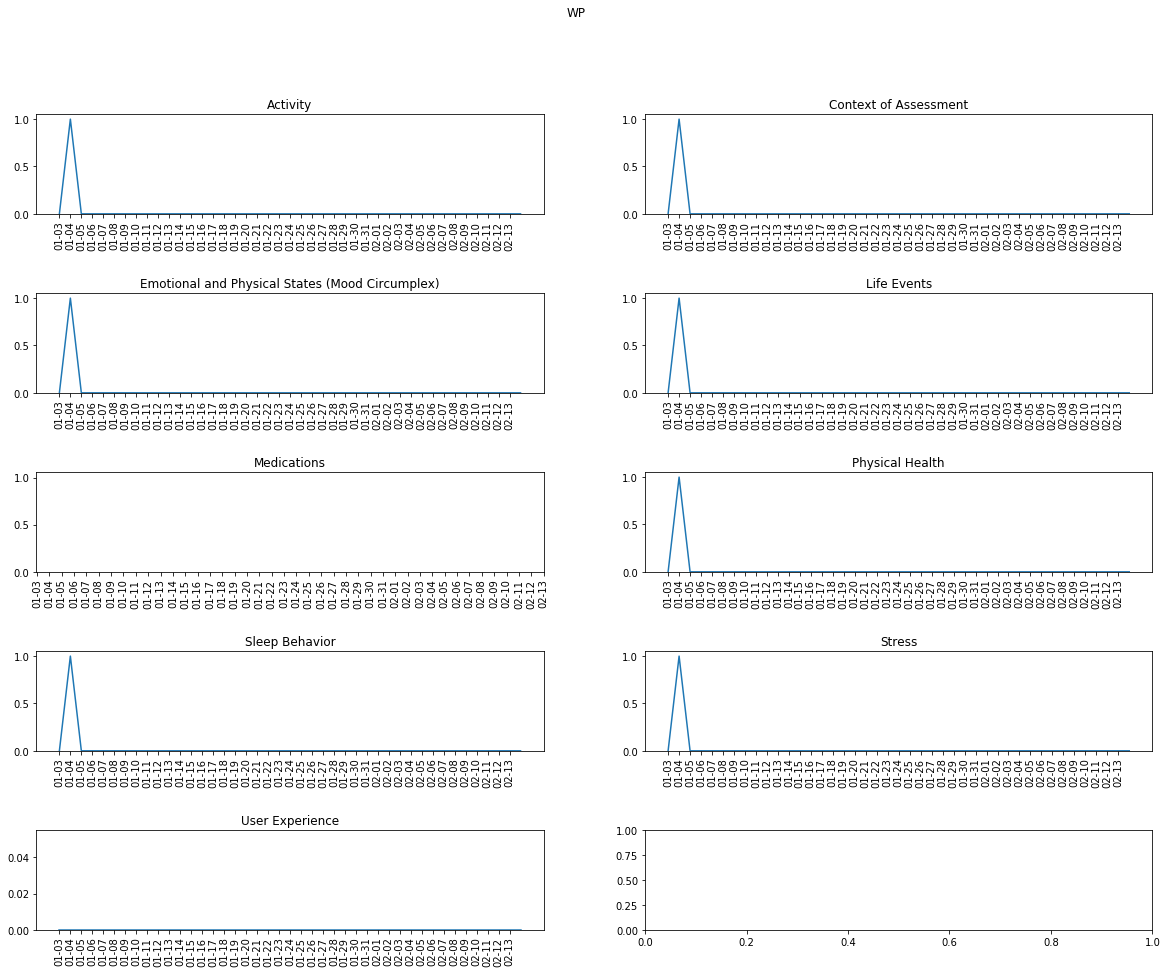

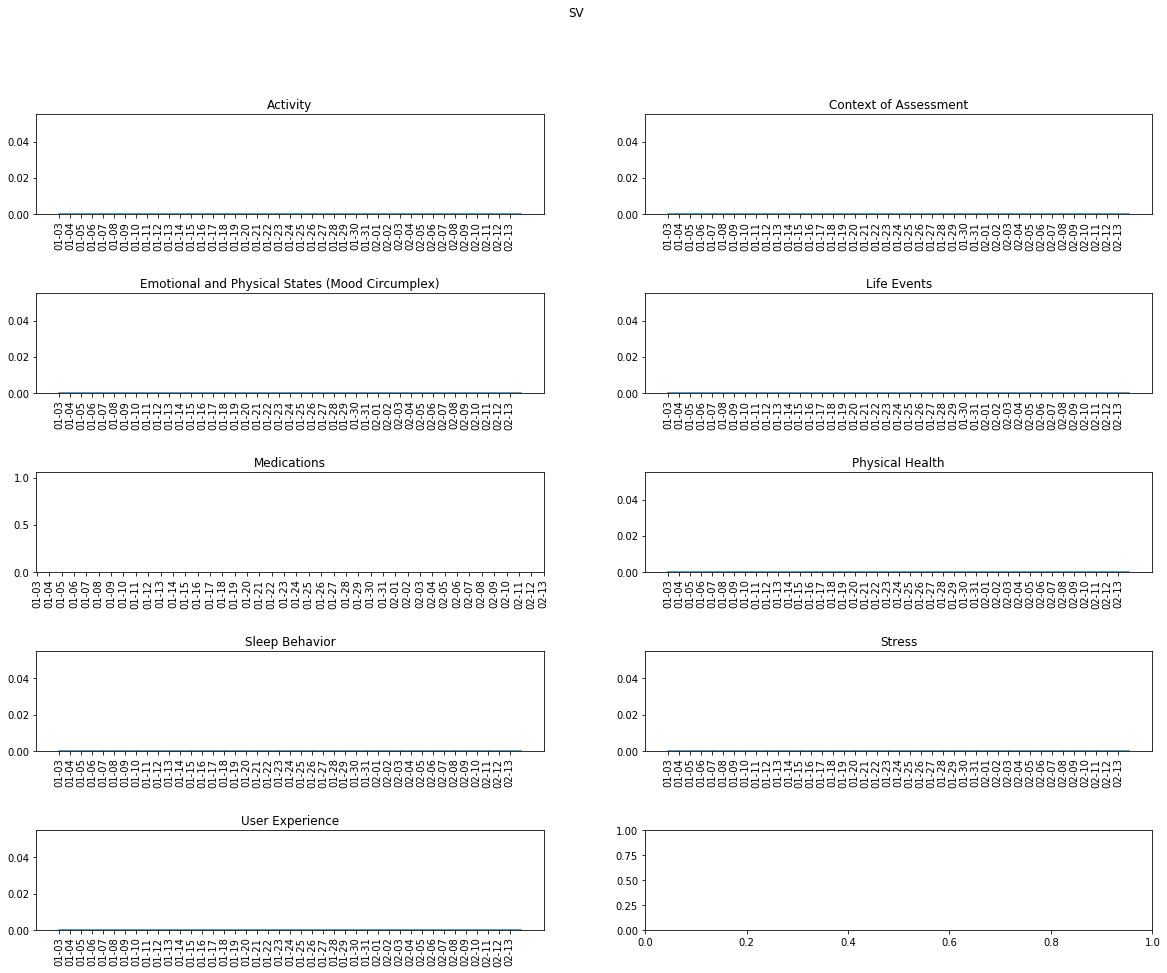

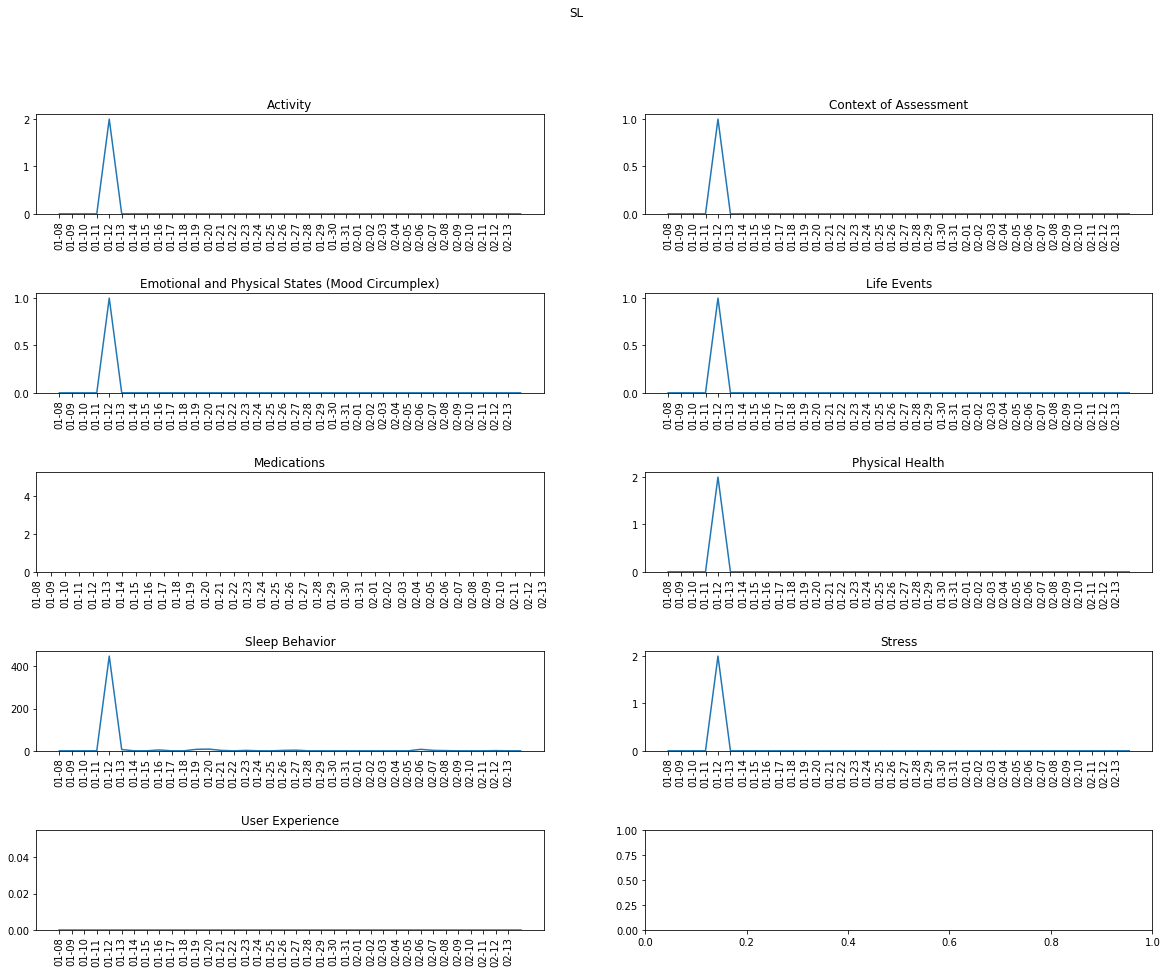

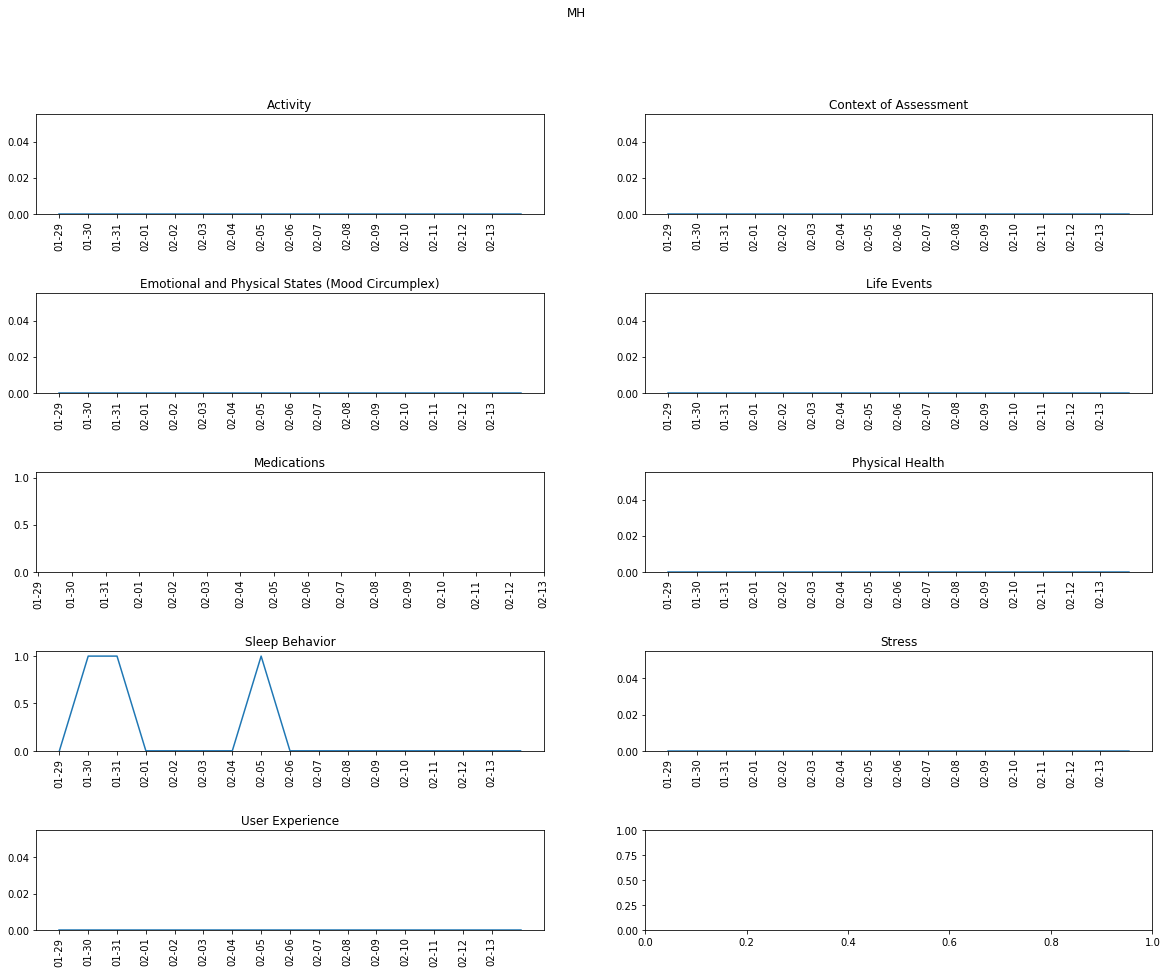

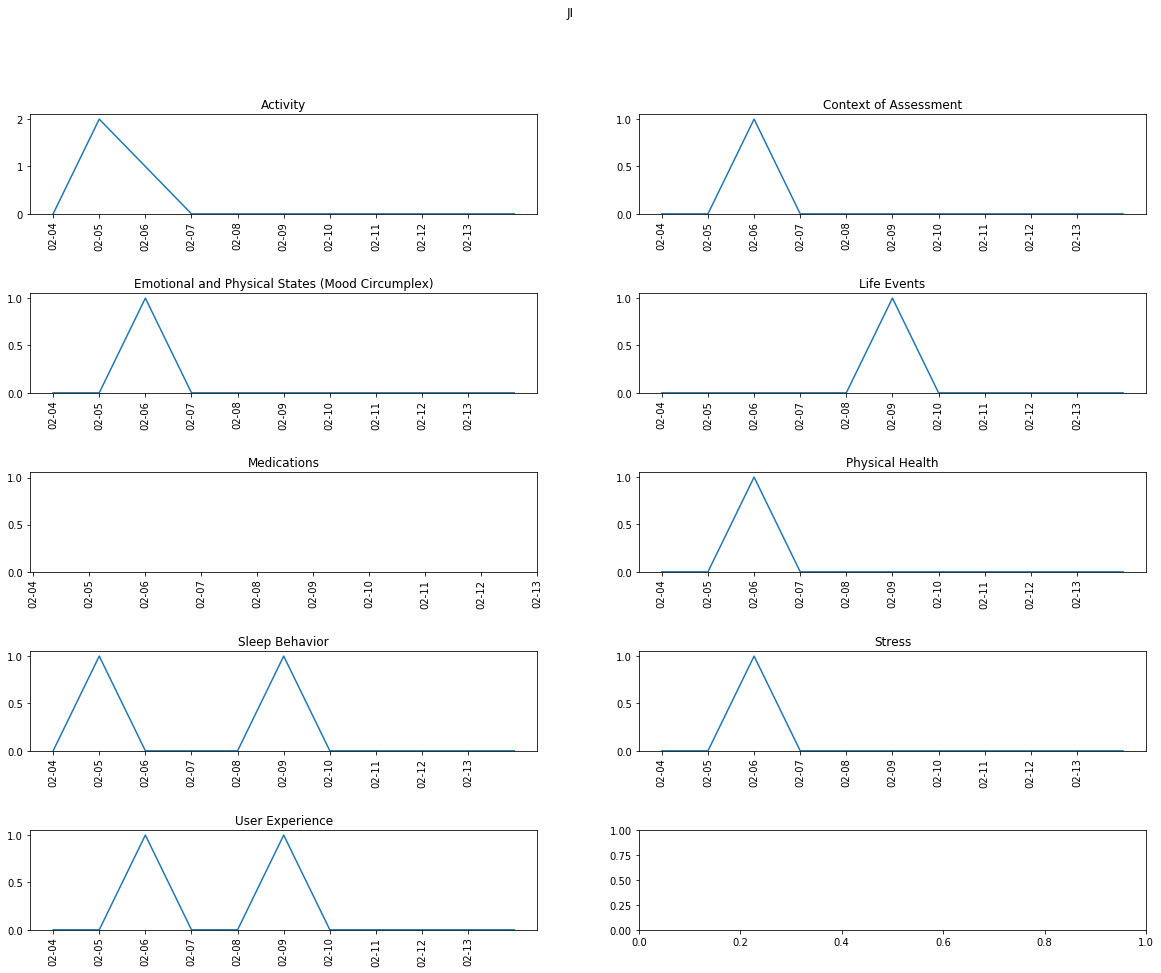

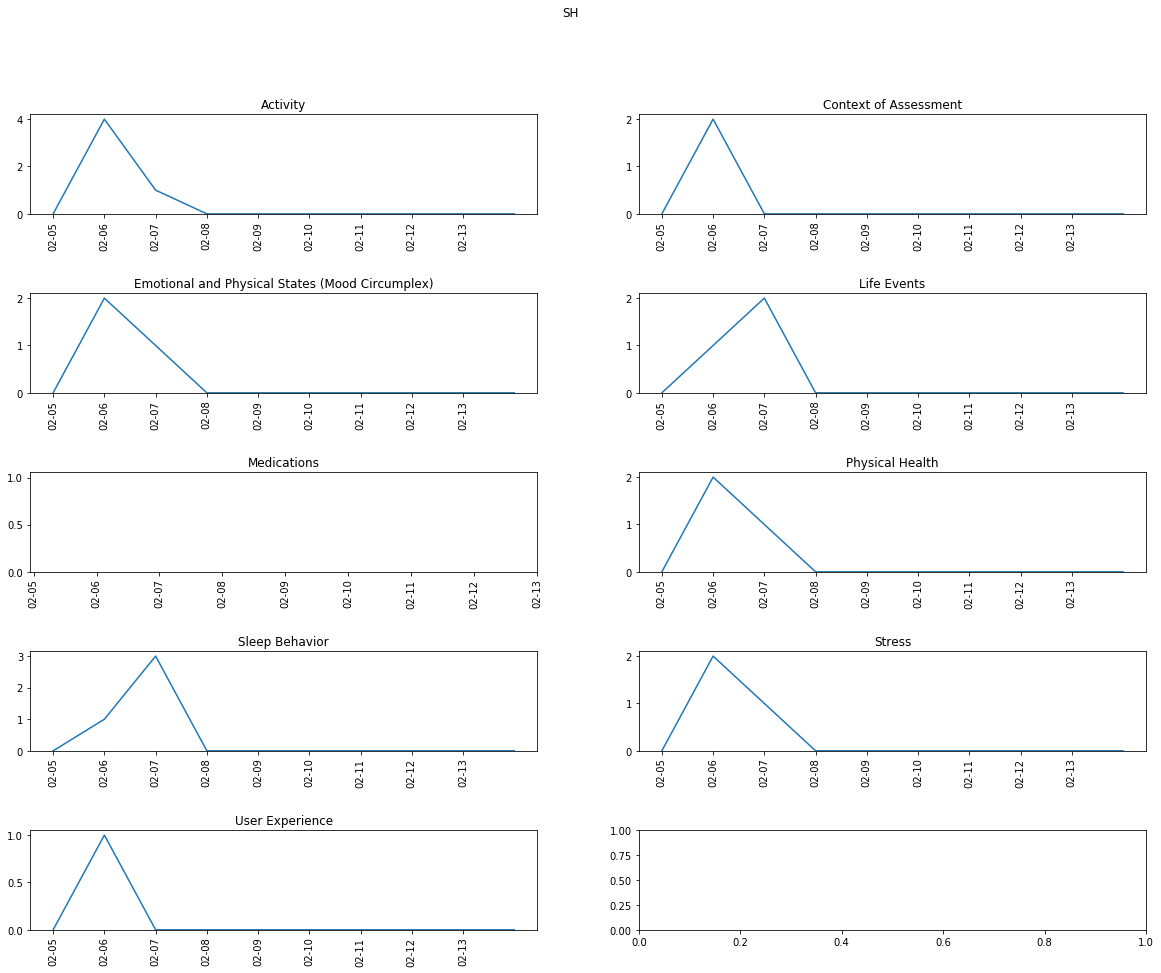

In [6]:
for user in binary:
    plot_responses(user)

In [7]:
with open(
    "reports/{}.txt".format(
        datetime.now().strftime(
            "%Y.%m.%d.%H.%M"
        )
    ),
    "w",
    encoding="utf-8"
) as fp:
    fp.write(report)
with open(
    "reports/{}-initials.txt".format(
        datetime.now().strftime(
            "%Y.%m.%d.%H.%M"
        )
    ),
    "w",
    encoding="utf-8"
) as fp:
    fp.write(initialsReport)

In [8]:
response_table[[col for col in response_table.columns if col not in ['created', 'name']]].dropna(how="all").shape

(6, 9)